In [1]:
using Gen
using Random
using Distributions
using StatsBase: mean, std, quantile
using BenchmarkTools
using FilePathsBase;
using LinearAlgebra: dot, Diagonal
using JSON
import PyPlot
plt = PyPlot.plt
using JLD

In [2]:
include("utils.jl");

In [3]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

# Overview

- prior occupancy map
- pose prior for such a map
- (range) sensor model for occupancy maps
- Naive map inference
- inverse sensor model (proposal for map posterior)

# Occupancy Map

In [5]:
abstract type Cell end


"""
    MapCell(x,v,i)

A single grid cell in an occupancy map.
"""
mutable struct MapCell <: Cell
    x::Vector{Float64}
    v::Float64
    i::CartesianIndex
end
# Rem: Could add resolution to each cell...
# ---

"""
    Map(cells, res)

An occupancy map containing cells of a fixed resolution.
(This could be made variable, and put on the individual cells.)
"""
mutable struct Map
    cells::Array{MapCell}
    res::Float64
end;

Berfore we continue we define a bunch of utility functions to deal with maps and so on.

In [6]:
Base.size(M::Map) = size(M.cells)
Base.size(M::Map, d::Int) = size(M.cells, d)
Base.iterate(M::Map) = iterate(M.cells)
Base.iterate(M::Map, state) = iterate(M.cells, state)
Base.getindex(M::Map, i) = M.cells[i]
Base.length(M::Map) = length(M.cells)
occupied(M::Map) = filter(c -> c.v == 1., M.cells)
walkable(M::Map) = filter(c -> c.v == 0., M.cells)
pos(c::MapCell) = c.x
val(c::MapCell) = c.v
pos(M::Map) = hcat(pos.(M.cells)...)
center(M::Map) = mean(pos.(M.cells))
function CartesianIndex(t::Int, M::Map)
    n = size(M.cells,1)
    i = mod(t-1,n) + 1 
    j = div(t - 1, n) + 1
    CartesianIndex(i, j)
end

center(size::Tuple{Int, Int}) = CartesianIndex(Int.(ceil.(size./2))...);
euclidean(z::Array{Float64,1}, a::Array{Float64,1}) = z .* [cos.(a) sin.(a)]
function norm2(A; dims)
    B = sum(x -> x^2, A; dims=dims)
    B .= sqrt.(B)
end;

In [7]:
function draw_map!(M::Map; ax=plt.gca(),m="o", s=nothing, alpha=.3, c="black")    
    ax.set_aspect(1)    
    x = hcat(pos.(occupied(M))...)
    ax.scatter(x[1,:],x[2,:], s=s, c=c,marker=m, alpha=alpha)
end;


function draw_map_im!(im::Array{T,2}; ax=plt.gca(), cmap="binary", vmin=-1, vmax=1) where T<: Real
    im = transpose(im)
    im = im[end:-1:1,:]
    ax.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)
end;


function draw_map_circles!(M::Map; ax=plt.gca(), alpha=.2, cmap="binary")    
    cm = plt.cm.get_cmap(cmap)
    ax.set_aspect(1);
    for c in occupied(M)
        circle1 = plt.Circle(c.x, M.res/2, color=cm(c.v), alpha=alpha)
        ax.add_patch(circle1)
    end
end;

In [8]:
"""
    Map(cs, res) = map_prior(map_size::Tuple{Int,Int}, 
                             res::Float64, 
                             pr::Float64)

Returns map of occupancy grid cells....

Choices:
```
    | 
    +-- (:m, CartesianIndex): Bool
```
"""
@gen function map_prior(map_size::Tuple{Int,Int}, 
                        res::Float64, 
                        pr::Float64)
    
    i0 = center(map_size)
    cs = Array{MapCell,2}(undef, map_size...)
    for i in CartesianIndices(map_size)    
        v = @trace(bernoulli(pr), (:m, i))
        cs[i] = MapCell(res.*Vec(i - i0), v, i)
    end

    return Map(cs, res)
end;

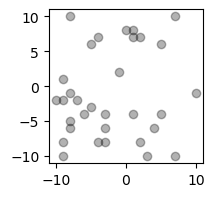

In [9]:
map_args = (map_size=(21,21), res=1., pr=0.1)
M = map_prior(map_args...)

#-----------------------
fig, ax = plt.subplots(1,1, figsize=(4,2));
draw_map!(M, ax=ax);

# Pose

In [10]:
"""
    Pose

Encoding the pose of a 2d agent as 
a 2d-position `x` and its head direction `hd`.
"""
struct Pose <: StructIterator
    x::Array{Float64}
    hd::Float64
end;

In [11]:
"""
    pose_prior(M::Map)

Samples a pose where the position is uniformly
chosen from the un-occupied cell-centers.

Choices:
```
    | 
    +-- (:hd, Float64)
    |
    +-- (:x,  Array{Float64})
```
"""
@gen function pose_prior(M::Map)
    free = walkable(M)
    len = length(free)
    
    hd ~ uniform(0,2π)
    x  ~ labeled_cat([pos.(free)...], ones(len)/len)
    return Pose(x,hd)
end;
# Rem: Note that pr(hd = -pi) = 0. We need to define a better distr over the unitcircle!
# ---  This was the source of a bug which took quite a bit to unravel...

In [12]:
function draw_pose!(pose; ax=plt.gca(), c="black", m="o", l=1., zorder=1)
    x, hd = pose
    nose = l.*[cos(hd) sin(hd)]
    ax.scatter(x..., c="w", marker="o", edgecolor=c, zorder=zorder+1)
    ax.plot([x[1];x[1]+nose[1]], [x[2];x[2]+nose[2]], c=c, zorder=zorder)
end;

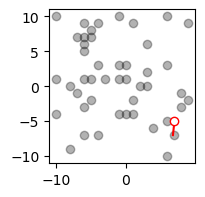

In [13]:
map_args = (map_size=(21,21), res=1., pr=0.1)
M = map_prior(map_args...)
pose = pose_prior(M)

#-----------------------
fig, ax = plt.subplots(1,1, figsize=(4,2));
draw_map!(M, ax=ax);
draw_pose!(pose, ax=ax, c="r", l=2.);

# Range sensor for grid maps

Next we define a simple range sensor for an occupancy map.
Let $x_1, \ldots, x_k$ denote the cell centers 
of all occupied cells in a given occupancy map $M$. Without loss of generality 
we assume that the agent is located at the origin, i.e. $x = 0$, otherwise we can always 
choose a different coordinate system for $M$ such that this is the case &mdash; just replace $x_j$ by $x'_j = x_j - x$. 

Let $l \in S^1$ denote the direction of a simulated laser beam based
at the origin. Then the orthogonal projection $y_j = y_{j,l}$ of $x_j$ onto $l$ is given by

$$
y_j = z_j \cdot l,
$$

where $z_j = z_{l,j} = \langle l, x_j \rangle$.

Only a subset of cells should should be taken into account when calculating the measurement along $l$.
To this end we define an $\varepsilon$-neighbourhood of the laser beam and only cells within that neighbourhood may influence the measurement along it. To be more precise, for $\varepsilon >0$ we only consider 
those cells for which $z_j > 0 $ and $d_j  = \| x_j - y_j \| < \varepsilon$. We define 
the measurement $z(l)$ as the distance to the closest of these filtered projections, that is

$$
            z(l) := \min\{ z_j \mid z_j > 0 \text{, and } d_j < \varepsilon \}.
$$

...Alternatively one could define a neighbourhood in polar-coordinates....illustrate differences, pros, cons...

In [14]:
"""
    angles(fov::Int64=180, n=100)

Range of angles from `-fov` degrees to `+fov` degrees,
however the entries are in radians not degrees.
"""
function angles(fov::Int64, n::Int)
    θ  = fov/180*π
    θs = collect(range(-θ, θ, length=n))
    return θs
end;

In [15]:
"""
    (Y, Z, D) = project(X, pose::Pose, a)

Project the columns of `X` onto the bouquet of lines 
based at `pose.x` and spanned by `a`.

The array `Y[i,:,j]` contains the projection of `X[:,j]`
onto the line based at `x` and spanned by `e^{i*(a[i] + hd)}`
where `(x, hd) = pose`...
"""
function project(X::Array{Float64,2}, pose::Pose, a::Array{Float64})
    x, hd = pose
    n = length(a)
    a = a .+ hd
    L = [cos.(a) sin.(a)] # size = (n,2)
    X = X .- x            # size = (2,c)
    Z = L * X             # size = (n,c)
    Y = reshape(Z, n, 1, :) .* L;   # size = (n,2,c)
    V = Y .- reshape(X,1,2,:)
    D = norm2(V, dims=2)[:,1,:]
    return Y, Z, D
end;

In [16]:
"""
    Measurement(z,a)

Sensor measurement containing depth values `z` and
the angles `a` of the simulated laser beams.
"""
struct Measurement <: StructIterator
    z::Vector{Float64} # range measurements
    a::Vector{Float64} # angles (pre-noise)
end;

In [17]:
"""
    occ_lidar(occ::Array{MapCell}, 
              pose::Pose, 
              eps::Float64, 
              fov::Int, 
              n::Int, 
              max_val::Float64)

Range sensor model for an occupancy map. Returns a 
range measuremnt at a pose form an array of occupied
map cells.
"""
function occ_lidar(occ, pose, eps, fov, n, max_val)
    a = angles(fov, n)     
    z = zeros(n)
    
    if length(occ) ==0
        z .= max_val
        return Measurement(z, a)
    end
    

    X = hcat(pos.(occ)...)
    Y,Z,D = project(X, pose, a)
    

    for i=1:n
        
        valid = (Z[i,:] .> 0.0) .* (D[i,:] .<= eps)
        
        if sum(valid) > 0
            z[i] = min([max_val; norm2(Y[i,:,valid], dims=1)]...)
        else
            z[i] = max_val
        end
    end
    return Measurement(z, a)
end;

In [18]:
function draw_sense!(z,a, pose; ax=plt.gca(), cmap=nothing, cs=nothing)
    y = euclidean(z, a .+ pose.hd) .+ pose.x'
    x = pose.x
        
    if cmap == nothing || cs ==nothing
        for i=1:n
            ax.plot([x[1], y[i,1]],[x[2], y[i,2]], c="C1", alpha=0.2, zorder=0);
        end
        ax.scatter(y[:,1], y[:,2], c="C1", alpha=1., s=1, zorder=0);
    else
        cm = plt.cm.get_cmap(cmap)
        for i=1:n
            ax.plot([x[1], y[i,1]],[x[2], y[i,2]], c=cm(cs[i]), alpha=0.2, zorder=0);
            ax.scatter(y[i,1], y[i,2], c=cm(cs[i]), alpha=1., s=1, zorder=0);
        end

            
    end
end;

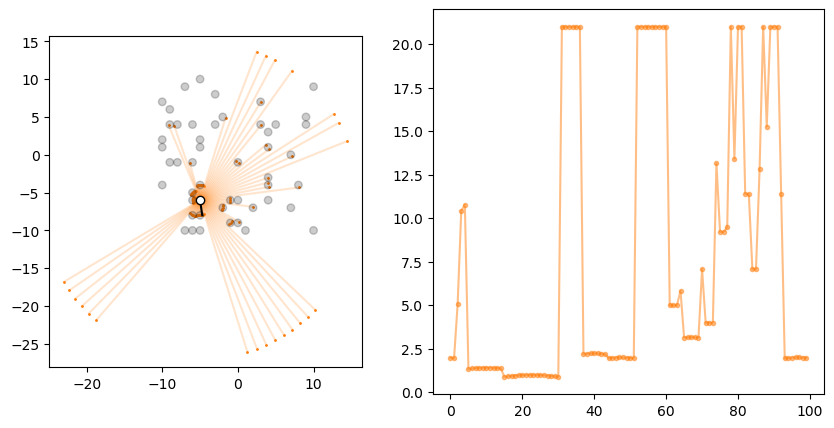

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fce77553050>

In [19]:
map_args = (map_size=(21,21), res=1., pr=0.1)
M = map_prior(map_args...)
pose = pose_prior(M)

fov = 180
n   = 100
max_val= M.res*max(size(M)...)
eps = M.res/2
occ = occupied(M)

z,a = occ_lidar(occ, pose, eps, fov, n, max_val)

#-----------------------
fig, axs = plt.subplots(1,2,figsize=(10,5), gridspec_kw=Dict("width_ratios" => [4,5]));
draw_sense!(z,a,pose; ax=axs[1])
draw_map_circles!(M; ax=axs[1])
draw_pose!(pose; ax=axs[1], c="black", l=2., zorder=2);
axs[2].plot(z, marker=".", c="C1", alpha=0.5)

# Sensor model 

In [20]:
"""
    Measurement(z, a) = sensor_model(M::Map, pose::Pose, fov, n, sig, max_val)

Range sensor model for an occupancy map.

Choices:
```
    |
    +-- :z : Array{Float64, 1}
```
"""
@gen function sensor_model(M::Map, pose::Pose, fov, n, sig, max_val)
    
    eps = M.res/2
    occ = occupied(M)

    mu_z, a = occ_lidar(occ, pose, eps, fov, n, max_val)
    
    sig_z = sig.*Diagonal(ones(n))
    z  = @trace(mvnormal(mu_z, sig_z), :z)
    
    return Measurement(z, a)
end;

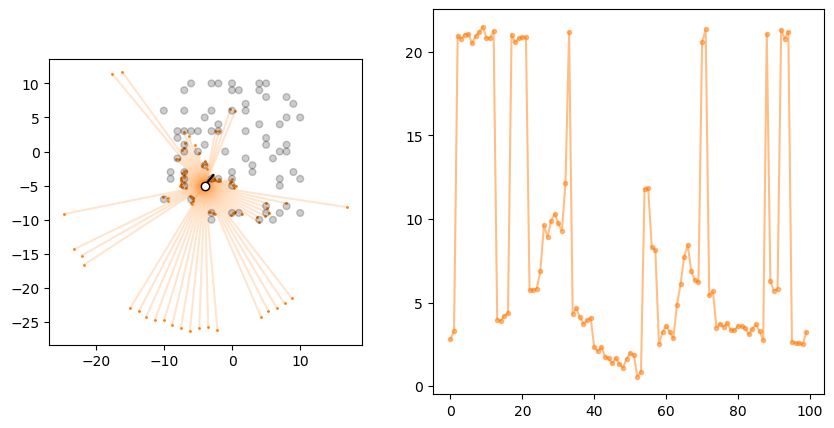

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fce7a093590>

In [24]:
map_size = (21, 21)
res = 1.

M    = map_prior(map_size, res, 0.2)
pose = pose_prior(M)

fov = 180
n   = 100
sig = 0.1
max_val = M.res*max(map_size...)


tr = simulate(sensor_model, (M, pose, fov, n, sig, max_val))
sense = get_retval(tr)
z,a = sense

#-----------------------
fig, axs = plt.subplots(1,2,figsize=(10,5), gridspec_kw=Dict("width_ratios" => [4,5]));
draw_sense!(z,a, pose; ax=axs[1])
draw_map_circles!(M; ax=axs[1])
draw_pose!(pose; ax=axs[1], c="black", l=2., zorder=2);
axs[2].plot(z, marker=".", c="C1", alpha=0.5)

# Inverse sensor model

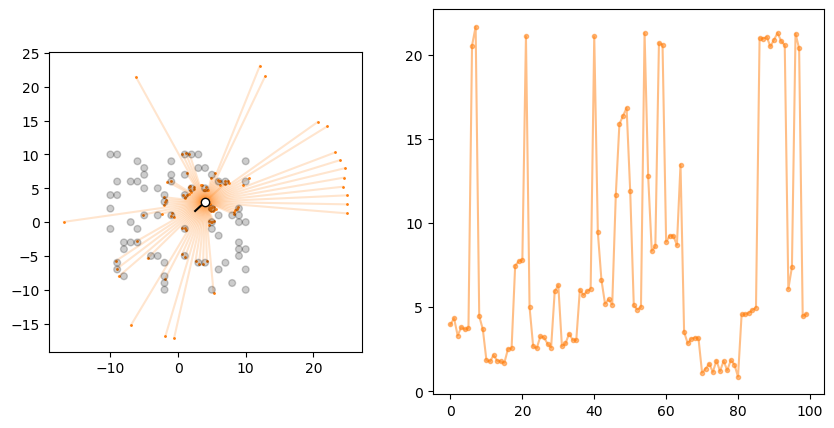

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fce7b0de050>

In [28]:
M    = map_prior(map_size, res, 0.2)
pose = pose_prior(M)
z,a  = sensor_model(M, pose, fov, n, sig, max_val)

#-----------------------
fig, axs = plt.subplots(1,2,figsize=(10,5), gridspec_kw=Dict("width_ratios" => [4,5]));
draw_sense!(z,a, pose; ax=axs[1])
draw_map_circles!(M; ax=axs[1])
draw_pose!(pose; ax=axs[1], c="black", l=2., zorder=2);
axs[2].plot(z, marker=".", c="C1", alpha=0.5)

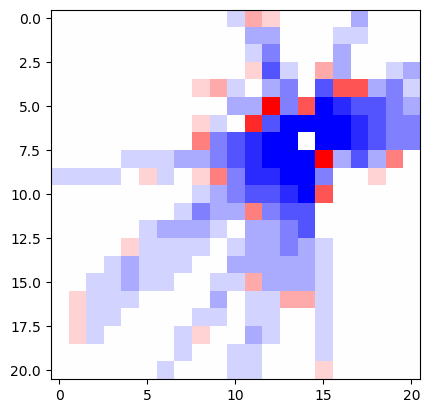

PyObject <matplotlib.image.AxesImage object at 0x7fce93715950>

In [29]:
im = zeros(size(M)...)
Y,Z,D = project(pos(M), pose, a);
eps = M.res/2
for i=1:length(a)
    z_cond = Z[i,:] .> 0
    eps_cond = (D[i,:] .< eps)
    cond = z_cond .* eps_cond
    occ  = cond .* (abs.(Z[i,:] .- z[i]) .< eps) 
    free = cond .* (Z[i,:] .- z[i] .+ eps .< 0)
    im[occ]  .+= 1
    im[free] .-= 1
end

draw_map_im!(im, cmap="bwr", vmin=-6, vmax=6)

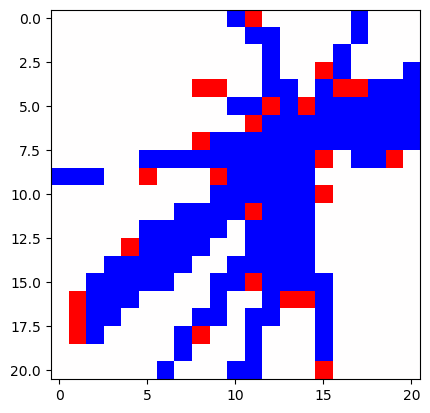

PyObject <matplotlib.image.AxesImage object at 0x7fce7af95f50>

In [30]:
im = zeros(size(M)...)
Y,Z,D = project(pos(M), pose, a);
# eps = sqrt(2*(M.res/2)^2)
eps = (M.res/2)

D[Z.<0] .= Inf
for j=1:length(M)
    i = argmin(D[:,j])
    if Z[i,j] < z[i] - eps
        im[j] -= 1
    elseif abs(Z[i,j] -  z[i]) <= eps
        im[j] += 1
    end
end

draw_map_im!(im, cmap="bwr", vmin=-1, vmax=1)

# Map Inference

In [131]:
"""
    model(map_size, res)

Model stringing together the map prior, pose_prior, and
the sensor model.

Choices:
```

    |
    +-- :M : tr(map_prior)
    |
    +-- :pose : tr(pose_prior_trace)
    |
    +-- :sense : tr(sensor_model)
```
"""
@gen function model(map_size, res)
    M     ~ map_prior(map_size, res, 0.2)
    pose  ~ pose_prior(M)
    sense ~ sensor_model(M, pose, 180, 100, res/4, res*max(map_size...))
    return M, pose, sense
end

model

In [132]:
function draw_tr!(tr; ax=plt.gca())
    M, pose, sense = get_retval(tr)
    z,a = sense

    ######
    ######
    draw_sense!(z, a, pose; ax=ax)
    draw_map_circles!(M; ax=ax)
    draw_pose!(pose; ax=ax, c="black", l=2., zorder=2);
end

draw_tr! (generic function with 1 method)

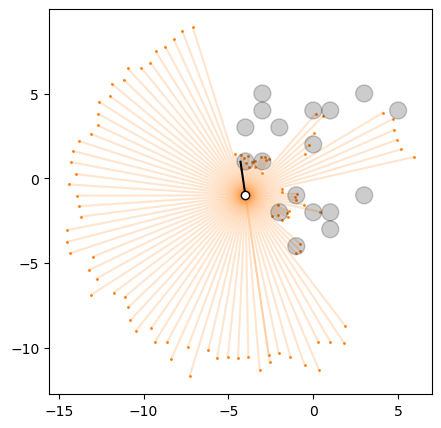

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa2e6aa1f10>

In [133]:
map_size=(10,10)
res = 1.

tr0 = simulate(model,(map_size, res))
ch = get_choices(tr0)

plt.figure(figsize=(5,5));
draw_tr!(tr0)

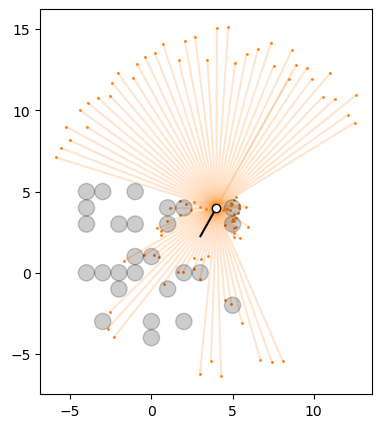

-4.290459441148391


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa2e0d00c50>

In [118]:
tr0[:pose]
constr = choicemap()
constr[:pose => :x] = tr0[:pose].x
tr0,w0 = generate(model,(map_size, res), constr)
# ch = get_choices(tr0)
println(w0)

plt.figure(figsize=(5,5));
draw_tr!(tr0)

## Naive map inference

In [248]:
constr = choicemap()
my_set_submap!(constr, :pose, get_choices(tr0));
my_set_submap!(constr, :sense, get_choices(tr0));

In [249]:
function infer_map(T, constr)
    trs, ws, = importance_sampling(model, (map_size, res), constr, T);
    tr = trs[argmax(ws)]
    return tr
end

infer_map (generic function with 2 methods)

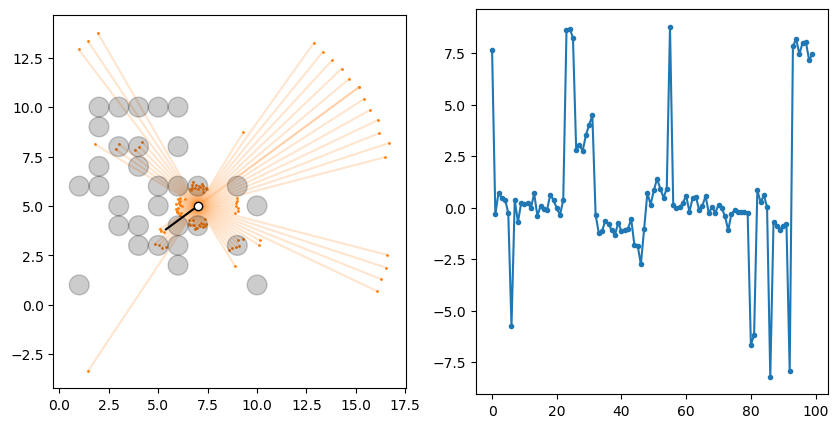

-57171.325053609056


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9cbc2c3cd0>

In [250]:
tr = infer_map(100, constr)
z, a = sensor_model(tr[:M], tr[:pose], 180, 100, 0.1, res*max(map_size...))
println(get_score(tr))
# -----------------
fig, axs = plt.subplots(1,2,figsize=(10,5));
draw_tr!(tr; ax=axs[1])
axs[2].plot(tr[:sense].z - z, marker=".")

## Less naive map inference

In [251]:
function infer_map_2(T, constr)

    tr, = generate(model, (map_size, res), constr)
    
    M, pose, sense = get_retval(tr)
    z,a = sense
    

    eps = M.res/2
    X = hcat(pos.(M.cells)...)
    Y,Z,D = project(X, pose, a)
    valid = (Z[:,:] .> 0.0) .* (D[:,:] .<= eps)
    
    cell_inds = collect(1:length(M.cells))
    
    for i=1:length(a)
        J = cell_inds[valid[i,:]]
        addrs = [:M => (:m,  CartesianIndex(j, M)) for j in J]
        selection = select(addrs...)
        
        for t=1:T
            tr, accepted = metropolis_hastings(tr, selection;  observations=constr)
        end
    end
    return tr
end;



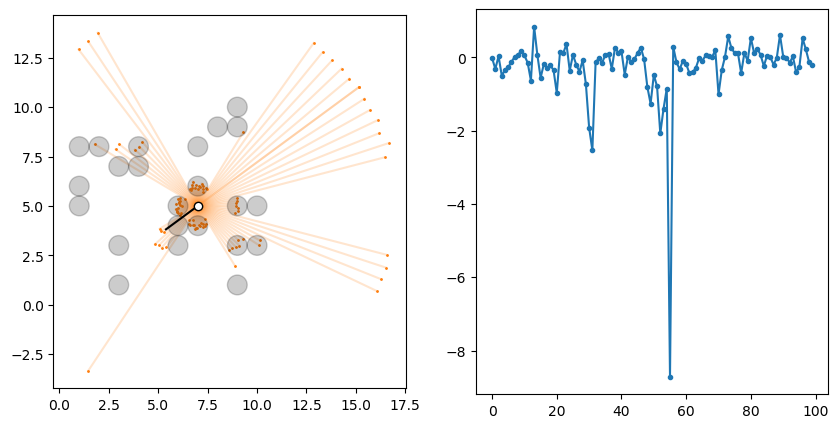

-4727.788671158874


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9cd1d4d890>

In [253]:
tr = infer_map_2(20, constr);
z, a = sensor_model(tr[:M], tr[:pose], 180, 100, 0.1, res*max(map_size...))
println(get_score(tr))
# -----------------
fig, axs = plt.subplots(1,2,figsize=(10,5));
draw_tr!(tr; ax=axs[1])
axs[2].plot(z - tr[:sense].z, marker=".")

## Inference from actual data

In [71]:
data = load("example_sensor_data.jld")

┌ Warning: JLD incorrectly extends FileIO functions (see FileIO documentation)
└ @ FileIO /Users/mirko/.julia/packages/FileIO/AmppF/src/loadsave.jl:210


Dict{String,Any} with 10 entries:
  "n"       => 100
  "s"       => [1.0, 1.0, 1.0, 1.0, 1.0, 0.523099, 0.558567, 1.0, 1.0, 1.0  …  …
  "fov"     => 180
  "hd"      => [-3.02165, -3.02165, -3.14084, -2.05469, -2.67697, -1.64092, -1.…
  "env_id"  => 2010
  "x"       => [9.40075 6.33549; 8.40794 6.21583; … ; 14.0901 0.411565; 13.3557…
  "z"       => Any[[1.46981, 1.48414, 1.50488, 1.53246, 1.5675, 1.61081, 1.6634…
  "a"       => Any[[-6.16324, -6.09977, -6.03631, -5.97284, -5.90937, -5.84591,…
  "dhd"     => [0.0, -0.119195, 1.08615, -0.622273, 1.03604, 0.191485, 1.46769,…
  "max_val" => Inf

In [72]:
function extract_poses(data)
    x   = data["x"]
    hd  = data["hd"]
    T   = length(hd)
    p = [Pose(x[t,:], hd[t]) for t=1:T]
    
    return p
end

function extract_measurments(data)
    z = data["z"]
    a = data["a"]
    sen = [Measurement(z[t],a[t]) for t=1:length(a)]
    return sen
end;

function extract_sensor_args(data)
    fov = data["fov"]
    n = data["n"]
    max_val = data["max_val"]
    return (fov=fov, n=n, max_val=max_val)
end;

In [74]:
function infer_map_3(model, args, constr, steps)

    tr, = generate(model, args, constr)
    
    M, pose, sense = get_retval(tr)
    z,a = sense
    

    eps = M.res/2
    X = hcat(pos.(M.cells)...)
    Y,Z,D = project(X, pose, a)
    valid = (Z[:,:] .> 0.0) .* (D[:,:] .<= eps)
    
    cell_inds = collect(1:length(M.cells))
    
    for i=1:length(a)
        
        J = cell_inds[valid[i,:]]
        addrs = [:M => (:m,  CartesianIndex(j, M)) for j in J]
        selection = select(addrs...)
        
        for t=1:step
            tr, accepted = metropolis_hastings(tr, selection;  observations=constr)
        end
    end
    return tr
end;


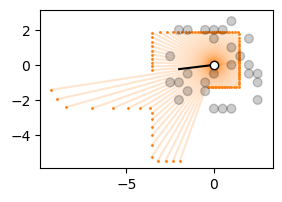

-2538.5919696748438


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa2e5623ed0>

In [124]:
sen = extract_measurments(data);
ps  = extract_poses(data);
constr = choicemap();
constr[:sense => :z] = sen[1].z;
constr[:pose => :x] = [0.0;0.0];
constr[:pose => :hd] = mod(ps[1].hd,2π);
# Rem: The modulo operation is crucial 
# ---  otherwise we get a -Inf score...

args = ((11,11), 0.5)
tr,w = generate(model, args, constr)
println(w)

plt.figure(figsize=(3,3));
draw_tr!(tr)

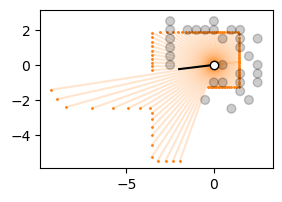

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa2e59ead50>

In [127]:
tr = infer_map_3(model, args, constr, 40)
plt.figure(figsize=(3,3));
draw_tr!(tr)

# Pose Inference

In [254]:
constr = choicemap()
my_set_submap!(constr, :sense, get_choices(tr));
my_set_submap!(constr, :M, get_choices(tr));

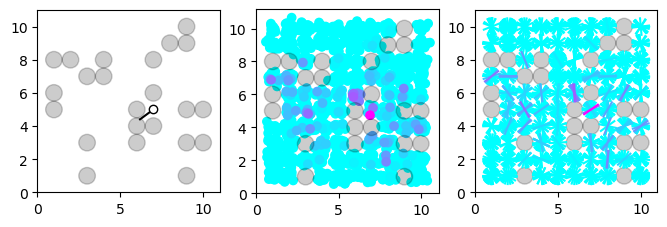

In [270]:
trs, ws, = importance_sampling(model, (map_size, res), constr, 1500);
perm = sortperm(ws)
trs = trs[perm]
ws = ws[perm]

q = quantile(ws, 0.9)
above = q .<= ws

cs = clamp.(ws, q, 0)
cs .-= min(cs...)
cs ./= max(cs...)


cm = plt.cm.get_cmap("cool")



fig, axs = plt.subplots(1,3,figsize=(8,4));
axs[2].set_aspect(1)

draw_map_circles!(tr[:M], alpha=0.2, ax=axs[1])
draw_pose!(tr[:pose], ax=axs[1])
draw_map_circles!(tr[:M], alpha=.2, ax=axs[2])

xs = hcat([tr_[:pose].x for tr_ in trs]...)
xs += randn(size(xs)...)*0.2
axs[2].scatter(xs[1,:],xs[2,:], c=cs[:], cmap="cool")




axs[3].set_aspect(1)
draw_map_circles!(tr[:M], alpha=.2, ax=axs[3])
for (tr_, c) in zip(trs, cs)
    x_, hd_ = tr_[:pose]

    nose = [cos(hd_); sin(hd_)]
    
    a = x_ - 0.5.*nose
    b = x_ + 0.5.*nose
    axs[3].plot([a[1],b[1]],[a[2],b[2]], c=cm(c))
end